# **Import Library**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load & Preprocessing Data**

In [23]:
# LOAD & PREPROCESSING DATASET PIMA
pima = pd.read_csv("/content/drive/MyDrive/Recondition Capstone/diabetes.csv")

In [24]:
# Ganti nilai 0 (yang artinya missing) dengan NaN
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
pima[cols_to_fix] = pima[cols_to_fix].replace(0, np.nan)
pima[cols_to_fix] = pima[cols_to_fix].fillna(pima[cols_to_fix].median())

In [25]:
# LOAD & PREPROCESSING DATASET NHANES
nhanes = pd.read_csv("/content/drive/MyDrive/Recondition Capstone/NHANES_age_prediction.csv")

In [26]:
# Ambil kolom relevan & ubah nama agar sesuai dengan Pima
nhanes_clean = nhanes[['RIDAGEYR', 'BMXBMI', 'LBXGLU', 'LBXIN', 'DIQ010']].copy()
nhanes_clean = nhanes_clean.rename(columns={
    'RIDAGEYR': 'Age',
    'BMXBMI': 'BMI',
    'LBXGLU': 'Glucose',
    'LBXIN': 'Insulin',
    'DIQ010': 'Outcome'
})

In [27]:
# Tambahkan kolom kosong agar strukturnya seragam dengan Pima
nhanes_clean['Outcome'] = nhanes_clean['Outcome'].replace({2: 0, 3: 0})
nhanes_clean['Pregnancies'] = 0
nhanes_clean['BloodPressure'] = np.nan
nhanes_clean['SkinThickness'] = np.nan
nhanes_clean['DiabetesPedigreeFunction'] = 0.5

In [28]:
# Susun ulang kolom
column_order = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
nhanes_clean = nhanes_clean[column_order]
nhanes_clean[cols_to_fix] = nhanes_clean[cols_to_fix].fillna(nhanes_clean[cols_to_fix].median())

# **Penggabungan Dataset**

In [29]:
# --- Gabungkan ---
combined_df = pd.concat([pima, nhanes_clean], ignore_index=True)

# **Penanganan Outlier**

In [30]:
# ========== OUTLIER HANDLING ==========
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

combined_df = remove_outliers_iqr(combined_df, cols_to_fix + ['Age'])

# **Pemilihan Fitur dan Normalisasi**

In [31]:
# ========== FEATURE & SCALING ==========
X = combined_df.drop(columns='Outcome')
y = combined_df['Outcome']

# Ambil kolom yang ingin digunakan
selected_features = ['Age', 'BMI', 'Glucose', 'Insulin', 'BloodPressure']
X = combined_df[selected_features]
y = combined_df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pastikan direktori ada
os.makedirs("model_artifacts", exist_ok=True)

# Simpan Model dan Scaler
joblib.dump(scaler, "model_artifacts/scaler.joblib")

['model_artifacts/scaler.joblib']

# **Penyeimbangan Data (SMOTE)**

In [32]:
# ========== BALANCING DATA ==========
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

# **Split Data**

In [33]:
# ========== SPLIT DATA ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

#  **Pembuatan Model MLP (Keras)**
# **Training Model**

In [34]:
# ========== MLP MODELING (TensorFlow) ==========
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5058 - loss: 0.7103 - val_accuracy: 0.5843 - val_loss: 0.6787
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6320 - loss: 0.6627 - val_accuracy: 0.6292 - val_loss: 0.6619
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6254 - loss: 0.6435 - val_accuracy: 0.6404 - val_loss: 0.6531
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7094 - loss: 0.6098 - val_accuracy: 0.6517 - val_loss: 0.6486
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7340 - loss: 0.5846 - val_accuracy: 0.6517 - val_loss: 0.6443
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7367 - loss: 0.5536 - val_accuracy: 0.6292 - val_loss: 0.6369
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7074 - loss: 0.5629 - val_accuracy: 0.6292 - val_loss: 0.6280
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7812 - loss: 0.5272 - val_accuracy: 0.64

# **Evaluasi Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
=== EVALUASI MODEL MLP ===
Akurasi: 78.38 %

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        56
         1.0       0.78      0.78      0.78        55

    accuracy                           0.78       111
   macro avg       0.78      0.78      0.78       111
weighted avg       0.78      0.78      0.78       111



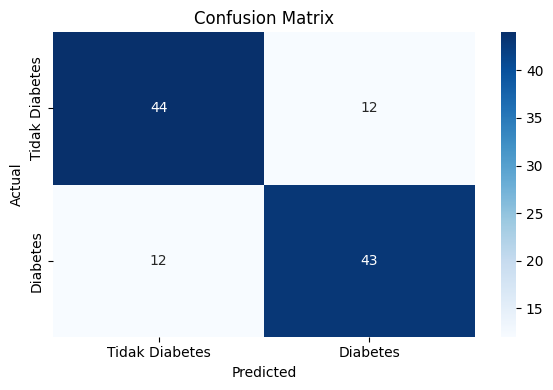

In [35]:
# ========== EVALUASI ==========
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("=== EVALUASI MODEL MLP ===")
print("Akurasi:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ['Tidak Diabetes', 'Diabetes']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

ROC-AUC: 0.8392857142857142


# **Simpan Model**

In [37]:
# ========== SIMPAN MODEL ==========
model.save("model_artifacts/diabetes_mlp_model.h5")
print("Model disimpan di model_artifacts sebagai diabetes_mlp_model.h5")

Model disimpan di model_artifacts sebagai diabetes_mlp_model.h5
